In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
import datetime, warnings, scipy
from scipy.optimize import curve_fit
from plotly_calplot import calplot

pd.set_option("display.max_columns", 500)
pal = sns.color_palette()

In [2]:
df = pd.read_csv("C:/Users/cj.alonzo/OneDrive - Nice Systems Ltd/Documents/Personal/Data Science/personal projects/delays/merged_data_with_airlines.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20604118 entries, 0 to 20604117
Data columns (total 23 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   TAIL_NUM             object 
 5   OP_CARRIER_FL_NUM    int64  
 6   ORIGIN               object 
 7   ORIGIN_CITY_NAME     object 
 8   DEST                 object 
 9   DEST_CITY_NAME       object 
 10  DEP_TIME             object 
 11  DEP_DELAY            float64
 12  DEP_DEL15            float64
 13  ARR_TIME             object 
 14  ARR_DELAY            float64
 15  ARR_DEL15            float64
 16  CARRIER_DELAY        float64
 17  WEATHER_DELAY        float64
 18  NAS_DELAY            float64
 19  SECURITY_DELAY       float64
 20  LATE_AIRCRAFT_DELAY  float64
 21  AIRLINE              object 
 22  DATE                 object 
dtypes: float64(9), int64(5), objec

In [4]:
#made a new column, date
df.rename(columns={'DAY_OF_MONTH': 'DAY'}, inplace=True)
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20604118 entries, 0 to 20604117
Data columns (total 23 columns):
 #   Column               Dtype         
---  ------               -----         
 0   YEAR                 int64         
 1   MONTH                int64         
 2   DAY                  int64         
 3   DAY_OF_WEEK          int64         
 4   TAIL_NUM             object        
 5   OP_CARRIER_FL_NUM    int64         
 6   ORIGIN               object        
 7   ORIGIN_CITY_NAME     object        
 8   DEST                 object        
 9   DEST_CITY_NAME       object        
 10  DEP_TIME             object        
 11  DEP_DELAY            float64       
 12  DEP_DEL15            float64       
 13  ARR_TIME             object        
 14  ARR_DELAY            float64       
 15  ARR_DEL15            float64       
 16  CARRIER_DELAY        float64       
 17  WEATHER_DELAY        float64       
 18  NAS_DELAY            float64       
 19  SECURITY_DELAY     

In [5]:
df.head()

YEAR  MONTH  DAY  DAY_OF_WEEK TAIL_NUM  OP_CARRIER_FL_NUM ORIGIN  \
0  2021      1    1            5   N131EV               4656    ATL   
1  2021      1    1            5   N131EV               4656    JAN   
2  2021      1    1            5   N131EV               4889    ATL   
3  2021      1    1            5   N131EV               4936    OKC   
4  2021      1    1            5   N132EV               4698    BHM   

        ORIGIN_CITY_NAME DEST         DEST_CITY_NAME  DEP_TIME  DEP_DELAY  \
0            Atlanta, GA  JAN  Jackson/Vicksburg, MS  14:46:00      256.0   
1  Jackson/Vicksburg, MS  ATL            Atlanta, GA  15:42:00      237.0   
2            Atlanta, GA  GSP              Greer, SC  20:44:00       14.0   
3      Oklahoma City, OK  ATL            Atlanta, GA  08:56:00      176.0   
4         Birmingham, AL  ATL            Atlanta, GA  15:00:00       -5.0   

   DEP_DEL15  ARR_TIME  ARR_DELAY  ARR_DEL15  CARRIER_DELAY  WEATHER_DELAY  \
0        1.0  15:02:00      249.0        1.0           49.0            0.0   
1        1.0  17:49:00      218.0        1.0            0.0            0.0   
2        0.0  21:28:00        7.0        0.0            0.0            0.0   
3        1.0  13:01:00      238.0        1.0            0.0          176.0   
4        0.0  17:01:00       -3.0        0.0            0.0            0.0   

   NAS_DELAY  SECURITY_DELAY  LATE_AIRCRAFT_DELAY       AIRLINE       DATE  
0        0.0             0.0                200.0  Endeavor Air 2021-01-01  
1        0.0             0.0                218.0  Endeavor Air 2021-01-01  
2        0.0             0.0                  0.0  Endeavor Air 2021-01-01  
3       62.0             0.0                  0.0  Endeavor Air 2021-01-01  
4        0.0             0.0                  0.0  Endeavor Air 2021-01-01

In [6]:
#converts the 'HHMM' string to datetime.time
def format_hour(string):
    if pd.isnull(string):
        return np.nan
    else:
        if string == 2400: string = 0
        string = "{0:04d}".format(int(string))
        hour = datetime.time(int(string[0:2]), int(string[2:4]))
        return hour

In [7]:
#combines a date and time to produce a datetime.datetime
def combine_date_hour(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

In [8]:
#combines two columns of the dataframe to create a datetime format
def create_flight_time(cleaned_df, col):    
    date = []
    for index, cols in cleaned_df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            date.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            date.append(combine_date_hour(cols))
        else:
            cols[1] = format_hour(cols[1])
            date.append(combine_date_hour(cols))
    return pd.Series(date)

In [9]:
#cleaned_df['DEP_TIME'] = cleaned_df['DEP_TIME'].apply(format_hour)
#cleaned_df['ARR_TIME'] = cleaned_df['ARR_TIME'].apply(format_hour)

In [10]:
#convert to string and then to datetime
#cleaned_df['DEP_TIME'] = pd.to_datetime(cleaned_df['DEP_TIME'].astype(str), format='%H:%M:%S', errors='coerce')

In [11]:
#cleaned_df['ARR_TIME'] = pd.to_datetime(cleaned_df['ARR_TIME'].astype(str), format='%H:%M:%S', errors='coerce')

In [12]:
#check make sure dep and arr time are datetime
print(df.dtypes)

YEAR                            int64
MONTH                           int64
DAY                             int64
DAY_OF_WEEK                     int64
TAIL_NUM                       object
OP_CARRIER_FL_NUM               int64
ORIGIN                         object
ORIGIN_CITY_NAME               object
DEST                           object
DEST_CITY_NAME                 object
DEP_TIME                       object
DEP_DELAY                     float64
DEP_DEL15                     float64
ARR_TIME                       object
ARR_DELAY                     float64
ARR_DEL15                     float64
CARRIER_DELAY                 float64
WEATHER_DELAY                 float64
NAS_DELAY                     float64
SECURITY_DELAY                float64
LATE_AIRCRAFT_DELAY           float64
AIRLINE                        object
DATE                   datetime64[ns]
dtype: object


In [13]:
df.head()

YEAR  MONTH  DAY  DAY_OF_WEEK TAIL_NUM  OP_CARRIER_FL_NUM ORIGIN  \
0  2021      1    1            5   N131EV               4656    ATL   
1  2021      1    1            5   N131EV               4656    JAN   
2  2021      1    1            5   N131EV               4889    ATL   
3  2021      1    1            5   N131EV               4936    OKC   
4  2021      1    1            5   N132EV               4698    BHM   

        ORIGIN_CITY_NAME DEST         DEST_CITY_NAME  DEP_TIME  DEP_DELAY  \
0            Atlanta, GA  JAN  Jackson/Vicksburg, MS  14:46:00      256.0   
1  Jackson/Vicksburg, MS  ATL            Atlanta, GA  15:42:00      237.0   
2            Atlanta, GA  GSP              Greer, SC  20:44:00       14.0   
3      Oklahoma City, OK  ATL            Atlanta, GA  08:56:00      176.0   
4         Birmingham, AL  ATL            Atlanta, GA  15:00:00       -5.0   

   DEP_DEL15  ARR_TIME  ARR_DELAY  ARR_DEL15  CARRIER_DELAY  WEATHER_DELAY  \
0        1.0  15:02:00      249.0        1.0           49.0            0.0   
1        1.0  17:49:00      218.0        1.0            0.0            0.0   
2        0.0  21:28:00        7.0        0.0            0.0            0.0   
3        1.0  13:01:00      238.0        1.0            0.0          176.0   
4        0.0  17:01:00       -3.0        0.0            0.0            0.0   

   NAS_DELAY  SECURITY_DELAY  LATE_AIRCRAFT_DELAY       AIRLINE       DATE  
0        0.0             0.0                200.0  Endeavor Air 2021-01-01  
1        0.0             0.0                218.0  Endeavor Air 2021-01-01  
2        0.0             0.0                  0.0  Endeavor Air 2021-01-01  
3       62.0             0.0                  0.0  Endeavor Air 2021-01-01  
4        0.0             0.0                  0.0  Endeavor Air 2021-01-01

In [14]:
#80% missing bc they werent delayed
((df.isnull().sum() / len(df)) * 100).sort_values(ascending = False)

#dep del15 should have so drop
#we'll drop tail num

ARR_DEL15              2.156841
ARR_DELAY              2.156841
ARR_TIME               1.940379
DEP_DELAY              1.865768
DEP_DEL15              1.865768
DEP_TIME               1.864666
TAIL_NUM               0.413311
AIRLINE                0.000000
LATE_AIRCRAFT_DELAY    0.000000
SECURITY_DELAY         0.000000
NAS_DELAY              0.000000
WEATHER_DELAY          0.000000
CARRIER_DELAY          0.000000
YEAR                   0.000000
MONTH                  0.000000
DEST_CITY_NAME         0.000000
DEST                   0.000000
ORIGIN_CITY_NAME       0.000000
ORIGIN                 0.000000
OP_CARRIER_FL_NUM      0.000000
DAY_OF_WEEK            0.000000
DAY                    0.000000
DATE                   0.000000
dtype: float64

In [15]:
# Drop rows with missing values in the specified columns
columns_with_missing = ['ARR_DEL15', 'ARR_DELAY', 'ARR_TIME', 'DEP_DELAY', 'DEP_DEL15', 'DEP_TIME', 'TAIL_NUM']
cleaned_df = df.dropna(subset=columns_with_missing)

# Verify the shape of the cleaned DataFrame
print("Original shape:", cleaned_df.shape)
print("Shape after dropping rows with missing values:", cleaned_df.shape)

Original shape: (20159720, 23)
Shape after dropping rows with missing values: (20159720, 23)


In [16]:
((cleaned_df.isnull().sum() / len(cleaned_df)) * 100).sort_values(ascending = False)

YEAR                   0.0
DEP_DEL15              0.0
AIRLINE                0.0
LATE_AIRCRAFT_DELAY    0.0
SECURITY_DELAY         0.0
NAS_DELAY              0.0
WEATHER_DELAY          0.0
CARRIER_DELAY          0.0
ARR_DEL15              0.0
ARR_DELAY              0.0
ARR_TIME               0.0
DEP_DELAY              0.0
MONTH                  0.0
DEP_TIME               0.0
DEST_CITY_NAME         0.0
DEST                   0.0
ORIGIN_CITY_NAME       0.0
ORIGIN                 0.0
OP_CARRIER_FL_NUM      0.0
TAIL_NUM               0.0
DAY_OF_WEEK            0.0
DAY                    0.0
DATE                   0.0
dtype: float64

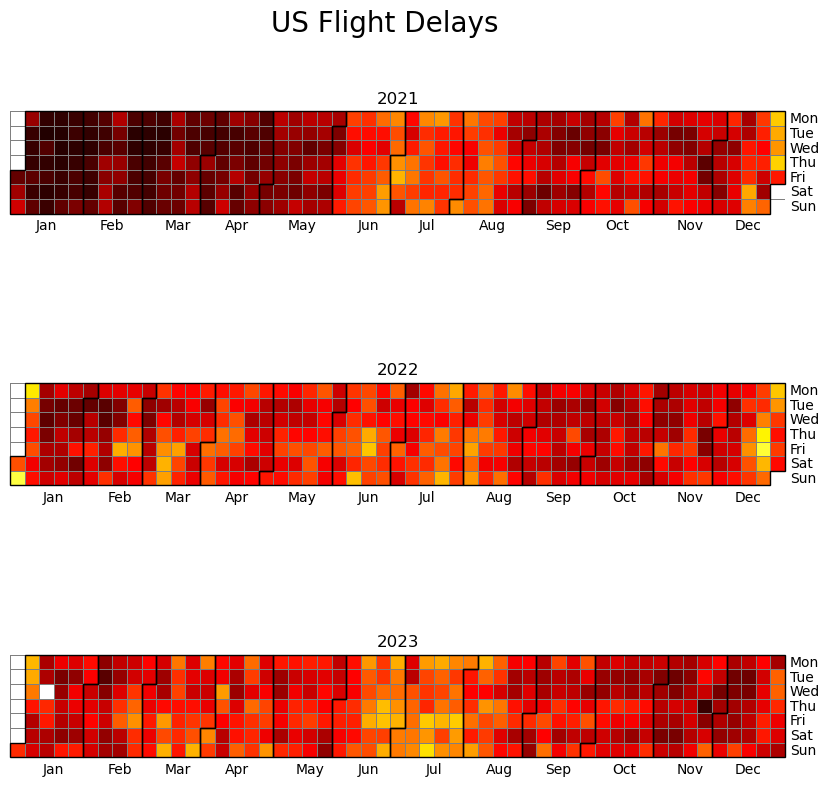

In [17]:
#a lot of delays in summer and christmas time. maybe more flights?

#group by "DATE" and count the number of delayed flights (DEP_DEL15 == 1)
delay_counts = cleaned_df.groupby("DATE")["DEP_DEL15"].apply(lambda x: (x == 1).sum())

#normalize the delay counts to the range [0, 1]
max_delay_count = delay_counts.max()
normalized_delay_counts = delay_counts / max_delay_count

#subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

#iterate over years and create year plots
for i, year in enumerate([2021, 2022, 2023]):
    #Year plot using calmap
    calmap.yearplot(
        delay_counts,  #Use delay counts as shading intensity
        year=year,
        cmap="hot",
        fillcolor="white",
        monthly_border=True,
        ax=axs[i],
        linewidth=0.5,
        linecolor="gray",
        vmin=0,  #Set minimum intensity to 0
        vmax=max_delay_count,  #Set maximum intensity to the maximum delay count
    )
    axs[i].set_title(year)

#plot properties
fig.patch.set_facecolor("white")
fig.suptitle("US Flight Delays", y=0.92, fontsize=20)
plt.show()

In [18]:
#interactive version
fig = calplot(delay_counts.apply(np.log).reset_index(), x="DATE", y="DEP_DEL15")
fig.show()

In [19]:
#columns of interest
columns_of_interest = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

#Carrier Delay is within the control of the air carrier like: plane cleaning, damage, waiting arrival of connecting passengers or crew, baggage, cargo, catering, etc
#Weather Delay is caused by extreme or hazardous forecasted weather conditions
#NAS Delay is within the control of the National Airspace System (NAS) like: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.
#Security Delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

#count the 1s in each column and sum them
delay_counts = cleaned_df[columns_of_interest].sum().sort_values(ascending = False)

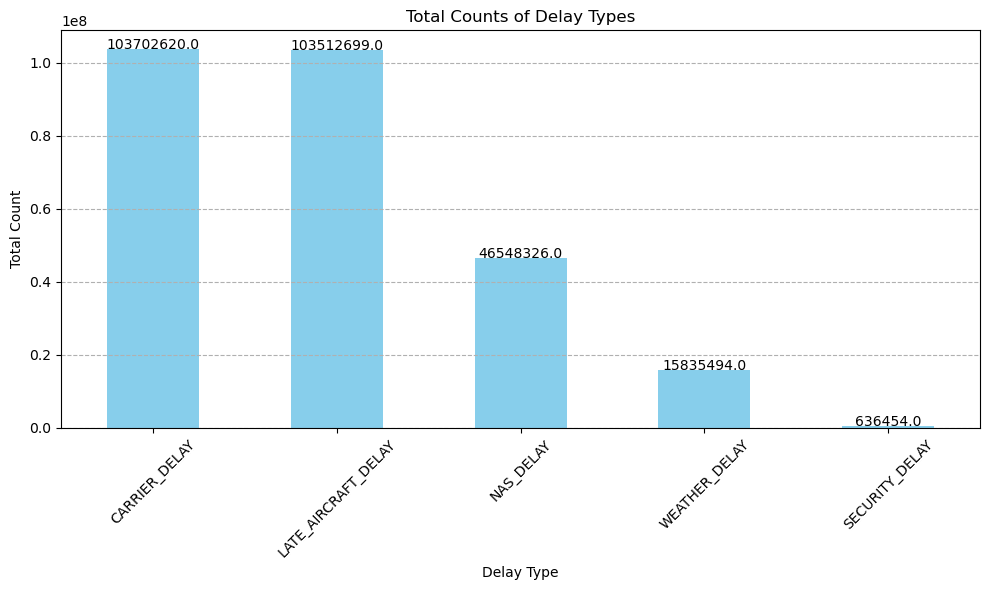

In [20]:
#bar graph
plt.figure(figsize=(10, 6))
delay_counts.plot(kind='bar', color='skyblue')
plt.title('Total Counts of Delay Types')
plt.xlabel('Delay Type')
plt.ylabel('Total Count')
plt.xticks(rotation=45)  #Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=1)

#text labels above each bar
for i, count in enumerate(delay_counts):
    plt.text(i, count + 0.1, str(count), ha='center')

plt.tight_layout()
plt.show()

In [21]:
#filter delays greater than 0 minutes and less than 30 minutes
filtered_delays = cleaned_df[(cleaned_df['DEP_DELAY'] > 0) & (cleaned_df['DEP_DELAY'] < 30)]

#group data by 'DEP_DELAY', count each unique variable, create a new column when resetting, and rename the column with the counts as Count
grouped_delay = filtered_delays.groupby('DEP_DELAY').size().reset_index().rename(columns={0: 'Count'})

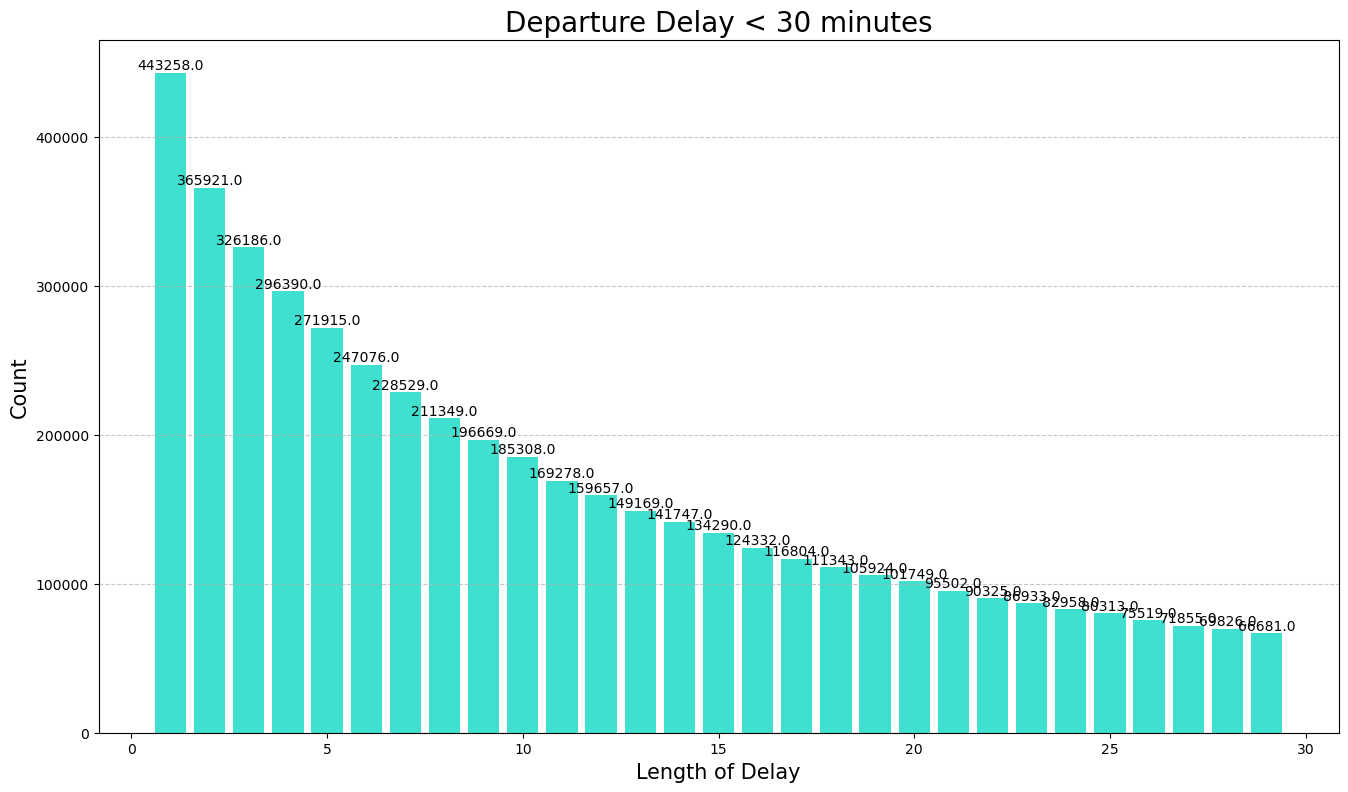

In [22]:
#bar graph
plt.figure(figsize=(16, 9))
plt.bar(data=grouped_delay, x='DEP_DELAY', height='Count', color='turquoise')

#Ttitle and axis labels
plt.title('Departure Delay < 30 minutes', fontsize=20)
plt.xlabel('Length of Delay', fontsize=15)
plt.ylabel('Count', fontsize=15)

#grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

#value labels above each bar
for index, row in grouped_delay.iterrows():
    plt.text(row['DEP_DELAY'], row['Count'], str(row['Count']), ha='center', va='bottom', fontsize=10)

plt.show()

In [23]:
#new column specifying how bad the delay was
cleaned_df["DelayGroup"] = None
cleaned_df.loc[cleaned_df["DEP_DELAY"] <= 0, "DelayGroup"] = "Early or On Time"
cleaned_df.loc[(cleaned_df["DEP_DELAY"] > 0) & (cleaned_df["DEP_DELAY"] <= 15), "DelayGroup"] = "Small Delay"
cleaned_df.loc[(cleaned_df["DEP_DELAY"] > 15) & (cleaned_df["DEP_DELAY"] <= 45), "DelayGroup"] = "Medium Delay"
cleaned_df.loc[cleaned_df["DEP_DELAY"] > 45, "DelayGroup"] = "Large Delay"

C:\Users\cj.alonzo\AppData\Local\Temp\ipykernel_19856\4125427310.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



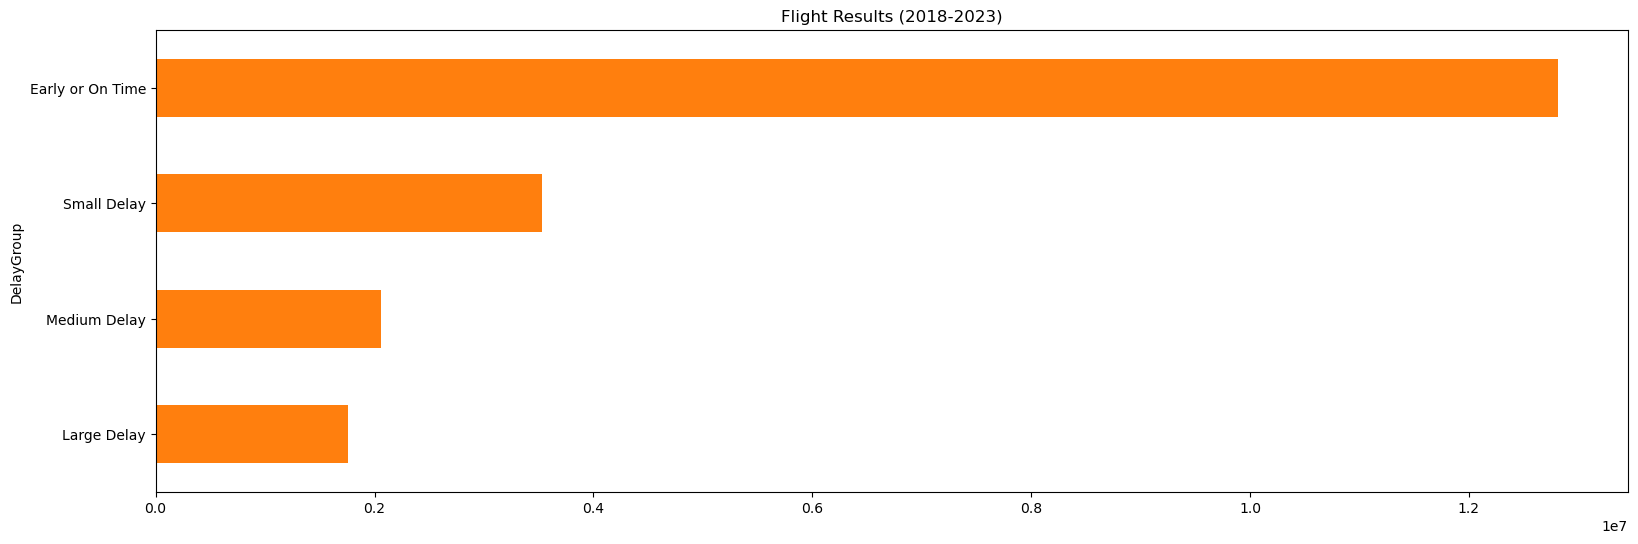

In [24]:
#most flights were early or on time
cleaned_df["DelayGroup"].value_counts(ascending=True).plot(
    kind="barh", figsize=(19, 6), color=pal[1], title="Flight Results (2018-2023)"
)
plt.show()

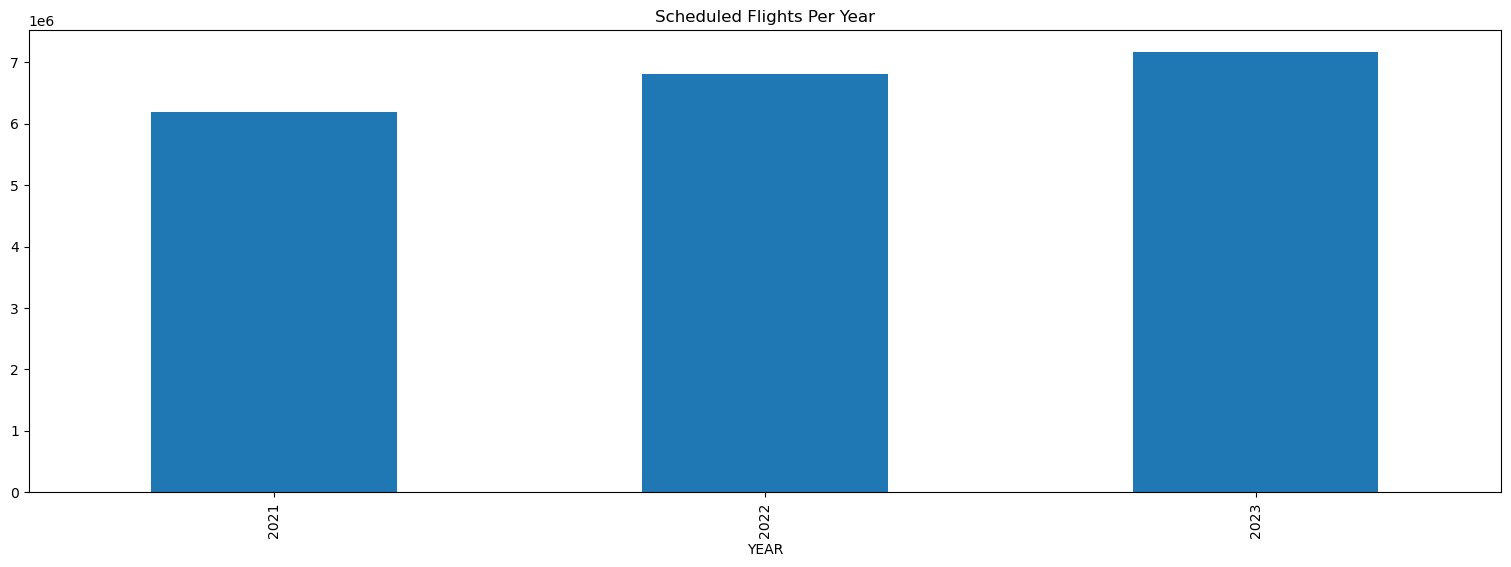

In [25]:
#more flights each year
cleaned_df["YEAR"].value_counts().sort_index().plot(
    kind="bar", figsize=(19, 6), title="Scheduled Flights Per Year"
)

plt.show()

In [26]:
#20mil+ flights
cleaned_df.shape

(20159720, 24)

In [27]:
#percentage of delays. more in summer or december!
cleaned_df_month = cleaned_df.groupby("MONTH")["DelayGroup"].value_counts(normalize=True).unstack() * 100
col_order = ["Early or On Time", "Small Delay", "Medium Delay", "Large Delay"]
cleaned_df_month[col_order].style.background_gradient(cmap="Blues")

In [28]:
#reset Description categories
cleaned_df["AIRLINE"] = cleaned_df["AIRLINE"].astype("str").astype("category")

#count each instance(flight) of airline
airline_counts = cleaned_df["AIRLINE"].value_counts()

print('Total Airline Flights \n', airline_counts, '\n')

Total Airline Flights 
 AIRLINE
Southwest Airlines Co.                     3721863
Delta Air Lines                            2593171
American Airlines                          2491826
SkyWest Airlines                           2121314
United Air Lines                           1772675
Republic Airline                            914376
JetBlue Airways                             728358
Envoy Air                                   716184
Endeavor Air                                685728
Spirit Air Lines                            669156
Alaska Airlines                             649440
PSA Airlines                                618362
Frontier Airlines                           459237
Mesa Airlines                               351877
Allegiant Air                               338693
Piedmont Airlines                           279209
Horizon Air                                 264462
CommuteAir LLC dba CommuteAir               219244
Hawaiian Airlines                           213181

C:\Users\cj.alonzo\AppData\Local\Temp\ipykernel_19856\200299542.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



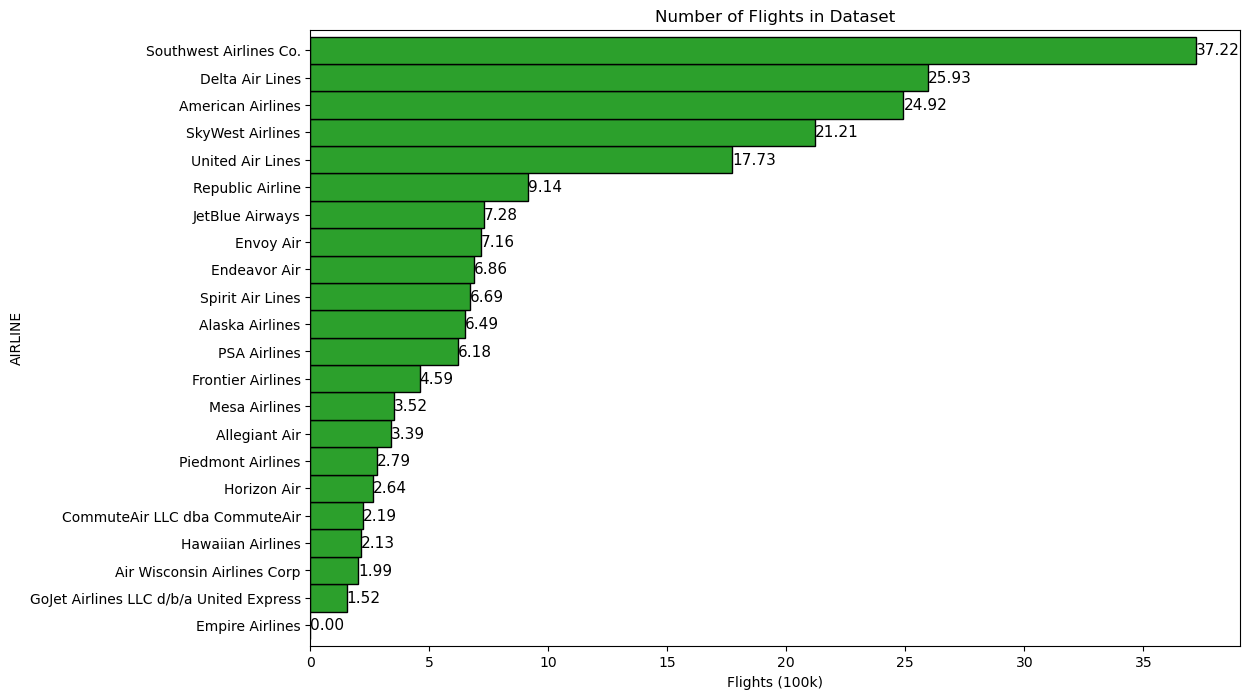

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

#horizontal bar plot
airlines_ordered = (cleaned_df["AIRLINE"].value_counts(ascending=True) / 100_000).plot(
    kind="barh", ax=ax, color=pal[2], width=1, edgecolor="black"
)

#count labels next to each bar
for bar in airlines_ordered.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():,.2f}',
             va='center', ha='left', fontsize=11)

ax.set_title("Number of Flights in Dataset")
ax.set_xlabel("Flights (100k)")
plt.show()

In [30]:
#group airline and delay group, calculate the normalized counts
cleaned_df_agg = (
    cleaned_df.groupby(["AIRLINE", "DelayGroup"])
    .size()
    .unstack()
    .fillna(0)
    .apply(lambda x: x / x.sum(), axis=1)
)

#count instances of each airline
airline_counts = cleaned_df["AIRLINE"].value_counts()

#filter airlines with at least 210000 flights
filtered_airlines = airline_counts[airline_counts >= 210000].index

#filter DataFrame based on selected airlines
cleaned_df_filtered = cleaned_df[cleaned_df["AIRLINE"].isin(filtered_airlines)]

In [31]:
delay_mapping = {
    "Early or On Time": "Good",
    "Small Delay": "Good",
    "Medium Delay": "Bad",
    "Large Delay": "Bad",
}

In [32]:
cleaned_df_filtered["DelayOk"] = cleaned_df_filtered["DelayGroup"].map(delay_mapping)

C:\Users\cj.alonzo\AppData\Local\Temp\ipykernel_19856\970250316.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
cleaned_df_filtered.head()

YEAR  MONTH  DAY  DAY_OF_WEEK TAIL_NUM  OP_CARRIER_FL_NUM ORIGIN  \
0  2021      1    1            5   N131EV               4656    ATL   
1  2021      1    1            5   N131EV               4656    JAN   
2  2021      1    1            5   N131EV               4889    ATL   
3  2021      1    1            5   N131EV               4936    OKC   
4  2021      1    1            5   N132EV               4698    BHM   

        ORIGIN_CITY_NAME DEST         DEST_CITY_NAME  DEP_TIME  DEP_DELAY  \
0            Atlanta, GA  JAN  Jackson/Vicksburg, MS  14:46:00      256.0   
1  Jackson/Vicksburg, MS  ATL            Atlanta, GA  15:42:00      237.0   
2            Atlanta, GA  GSP              Greer, SC  20:44:00       14.0   
3      Oklahoma City, OK  ATL            Atlanta, GA  08:56:00      176.0   
4         Birmingham, AL  ATL            Atlanta, GA  15:00:00       -5.0   

   DEP_DEL15  ARR_TIME  ARR_DELAY  ARR_DEL15  CARRIER_DELAY  WEATHER_DELAY  \
0        1.0  15:02:00      249.0        1.0           49.0            0.0   
1        1.0  17:49:00      218.0        1.0            0.0            0.0   
2        0.0  21:28:00        7.0        0.0            0.0            0.0   
3        1.0  13:01:00      238.0        1.0            0.0          176.0   
4        0.0  17:01:00       -3.0        0.0            0.0            0.0   

   NAS_DELAY  SECURITY_DELAY  LATE_AIRCRAFT_DELAY       AIRLINE       DATE  \
0        0.0             0.0                200.0  Endeavor Air 2021-01-01   
1        0.0             0.0                218.0  Endeavor Air 2021-01-01   
2        0.0             0.0                  0.0  Endeavor Air 2021-01-01   
3       62.0             0.0                  0.0  Endeavor Air 2021-01-01   
4        0.0             0.0                  0.0  Endeavor Air 2021-01-01   

         DelayGroup DelayOk  
0       Large Delay     Bad  
1       Large Delay     Bad  
2       Small Delay    Good  
3       Large Delay     Bad  
4  Early or On Time    Good

In [34]:
#group by airline and delay group, calculate the normalized counts again
cleaned_df_agg = (
    cleaned_df_filtered.groupby(["AIRLINE", "DelayGroup"])
    .size()
    .unstack()
    .fillna(0)
    .apply(lambda x: x / x.sum(), axis=1)
)

#sort the airlines based on total flights
cleaned_df_agg_sorted = cleaned_df_agg.loc[airline_counts.loc[filtered_airlines].sort_values(ascending=True).index]

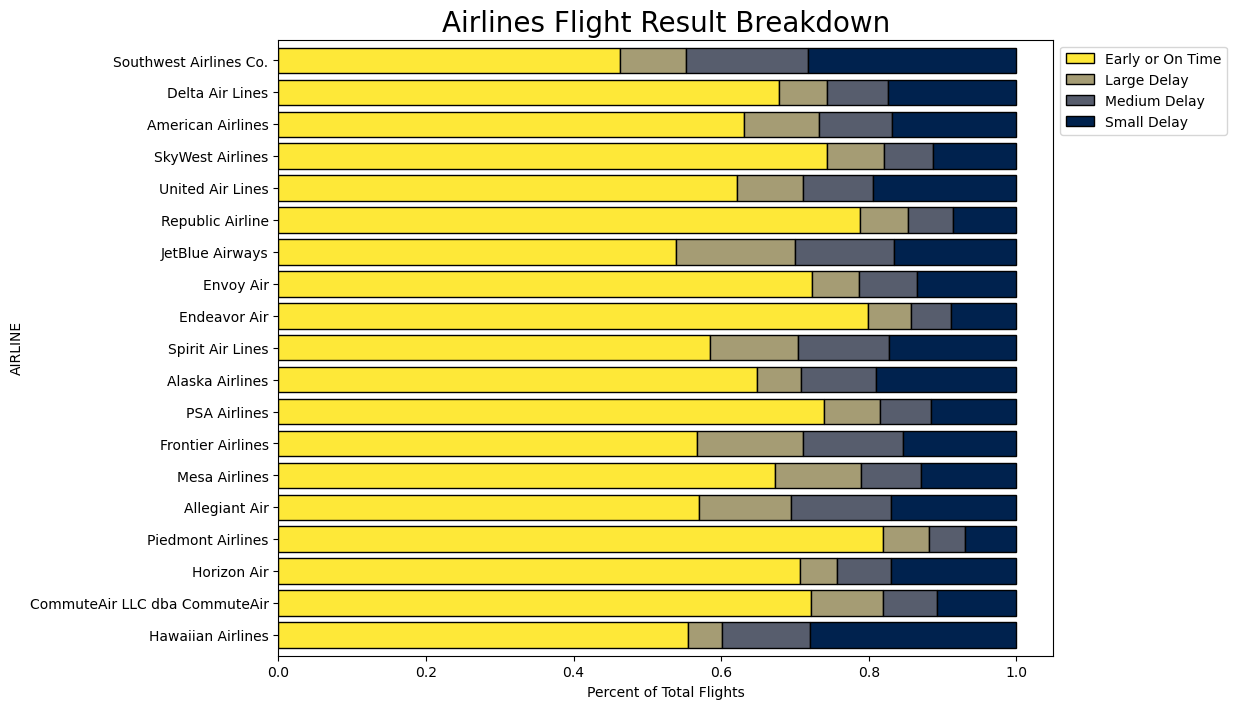

In [35]:
#choose a colormap (e.g., 'viridis')
cmap = plt.get_cmap('cividis_r')

#stacked bar plot with colormap
fig, ax = plt.subplots(figsize=(10, 8))
cleaned_df_agg_sorted.plot(kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black", colormap=cmap)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Airlines Flight Result Breakdown", fontsize=20)
ax.set_xlabel("Percent of Total Flights")
plt.show()

In [36]:
#group by airline and delay group, calculate the normalized counts again
cleaned_df_agg = (
    cleaned_df_filtered.groupby(["AIRLINE"])["DelayOk"]
    .value_counts(normalize=True)
    .unstack()[["Good", "Bad"]]
)

#count instances of each airline
airline_counts = cleaned_df_filtered["AIRLINE"].value_counts()

#sort the airlines based on the most "Good" delays
cleaned_df_agg_sorted = cleaned_df_agg.loc[filtered_airlines].sort_values(by="Good", ascending=False)

#display the sorted DataFrame
print(cleaned_df_agg_sorted)

DelayOk                            Good       Bad
AIRLINE                                          
Piedmont Airlines              0.888965  0.111035
Endeavor Air                   0.887521  0.112479
Horizon Air                    0.876262  0.123738
Republic Airline               0.873637  0.126363
SkyWest Airlines               0.856730  0.143270
Envoy Air                      0.856513  0.143487
PSA Airlines                   0.855355  0.144645
Delta Air Lines                0.852060  0.147940
Alaska Airlines                0.838529  0.161471
Hawaiian Airlines              0.835468  0.164532
CommuteAir LLC dba CommuteAir  0.828255  0.171745
United Air Lines               0.815595  0.184405
Mesa Airlines                  0.802312  0.197688
American Airlines              0.798611  0.201389
Spirit Air Lines               0.757517  0.242483
Southwest Airlines Co.         0.744422  0.255578
Allegiant Air                  0.739897  0.260103
Frontier Airlines              0.720643  0.279357


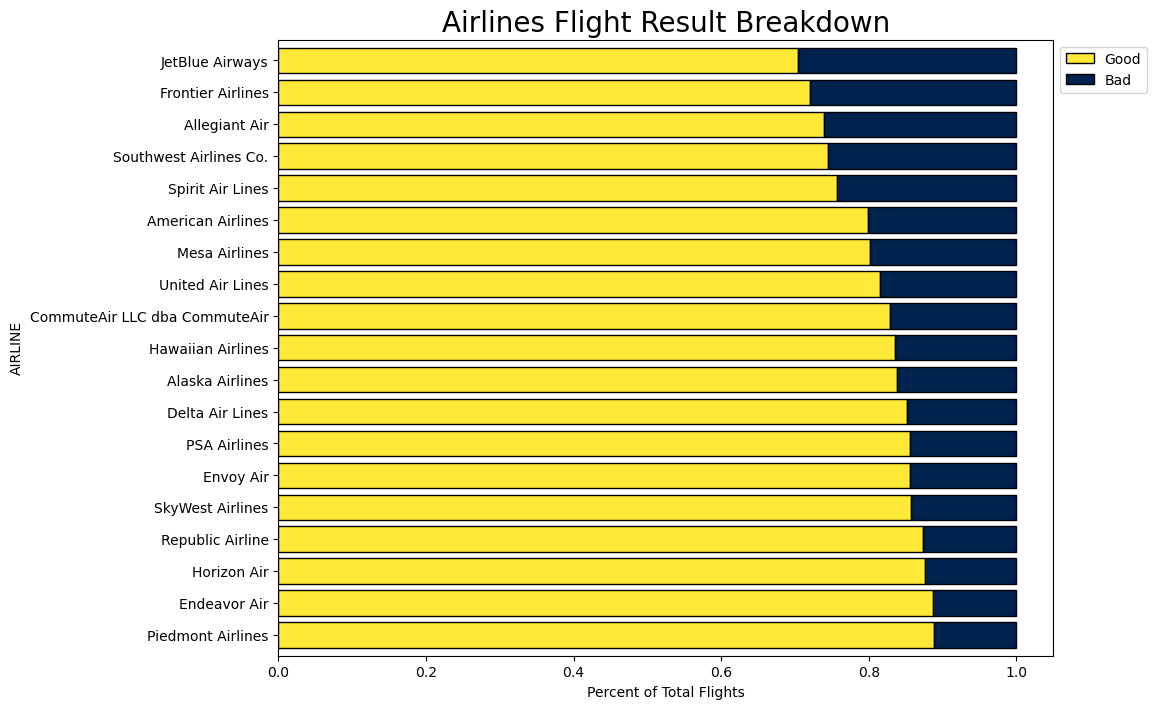

In [37]:
#stacked bar plot
fig, ax = plt.subplots(figsize=(10, 8))
cleaned_df_agg_sorted.plot(kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black", colormap=cmap)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Airlines Flight Result Breakdown", fontsize=20)
ax.set_xlabel("Percent of Total Flights")
plt.show()

In [38]:
#define a function to calculate stats
def get_stats(x):
    return pd.Series({
        'min': x.min(),
        'max': x.max(),
        'count': x.count(),
        'mean': x.mean()
    })

In [39]:
#stats for mean delays per airport
airport_stats = cleaned_df['DEP_DELAY'].groupby(cleaned_df['ORIGIN_CITY_NAME']).apply(get_stats).unstack()

#sort the statistics by count in descending order
airport_stats = airport_stats.sort_values('mean', ascending=False)

print(airport_stats)

                   min     max   count       mean
ORIGIN_CITY_NAME                                 
Pago Pago, TT    -31.0  1551.0   202.0  44.920792
Bishop, CA       -23.0  1207.0   590.0  31.638983
Santa Maria, CA  -30.0  1332.0   547.0  25.663620
Stockton, CA     -30.0  1393.0  1776.0  25.084459
Aguadilla, PR    -40.0  1387.0  6683.0  24.837049
...                ...     ...     ...        ...
Kotzebue, AK     -99.0   264.0  1928.0  -3.037344
Nome, AK         -38.0   438.0  1922.0  -3.263788
Saipan, TT       -41.0   664.0  1041.0  -5.826129
Gustavus, AK     -39.0   119.0   268.0  -6.671642
Deadhorse, AK    -45.0   434.0  1247.0  -7.362470

[374 rows x 4 columns]


In [40]:
#create a dataframe with stats on each airline based on delay LENGTH
global_stats = cleaned_df['DEP_DELAY'].groupby(cleaned_df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('mean', ascending = False)
global_stats

min     max      count       mean
AIRLINE                                                                     
JetBlue Airways                          -73.0  2508.0   728358.0  21.685740
Frontier Airlines                        -59.0  1393.0   459237.0  18.648942
Mesa Airlines                            -35.0  2186.0   351877.0  16.760260
Allegiant Air                            -45.0  2065.0   338693.0  16.338312
Spirit Air Lines                         -52.0  1587.0   669156.0  15.507214
American Airlines                        -47.0  4413.0  2491826.0  14.858477
Southwest Airlines Co.                   -52.0   775.0  3721863.0  13.062114
CommuteAir LLC dba CommuteAir            -34.0  1464.0   219244.0  12.731030
Air Wisconsin Airlines Corp              -43.0  1498.0   199304.0  12.460096
United Air Lines                        -105.0  1652.0  1772675.0  11.576812
GoJet Airlines LLC d/b/a United Express  -44.0  1653.0   151948.0  11.362025
SkyWest Airlines                         -72.0  5995.0  2121314.0   9.758937
Delta Air Lines                          -60.0  1311.0  2593171.0   8.865507
PSA Airlines                             -53.0  4225.0   618362.0   7.573755
Hawaiian Airlines                        -46.0  1847.0   213181.0   7.468700
Envoy Air                                -45.0  5327.0   716184.0   6.866717
Endeavor Air                             -90.0  1973.0   685728.0   6.073499
Republic Airline                         -56.0  7223.0   914376.0   5.580630
Alaska Airlines                          -99.0  1280.0   649440.0   5.568804
Horizon Air                              -38.0   979.0   264462.0   4.799483
Piedmont Airlines                        -41.0  1856.0   279209.0   4.030164
Empire Airlines                          -11.0    85.0      112.0   1.848214

In [41]:
#delay across all airlines
overall_mean_delay = cleaned_df['DEP_DELAY'].mean()

#standard deviation of the mean delays across airlines
std_dev_mean_delay = cleaned_df['DEP_DELAY'].groupby(cleaned_df['AIRLINE']).mean().std()

#range around the overall mean delay
lower_bound = overall_mean_delay - std_dev_mean_delay
upper_bound = overall_mean_delay + std_dev_mean_delay

#calculate middle of the range
middle_delay = (lower_bound + upper_bound) / 2

#calculate difference needed to reach the lower and upper bounds
lower_difference = overall_mean_delay - lower_bound
upper_difference = upper_bound - overall_mean_delay

In [42]:
#stat results
print(f"Mean Delay Range: {lower_bound:.2f} to {upper_bound:.2f} minutes")
print(f"Average delay is {middle_delay:.2f} ±{lower_difference:.2f} minutes")

Mean Delay Range: 6.14 to 16.63 minutes
Average delay is 11.38 ±5.24 minutes


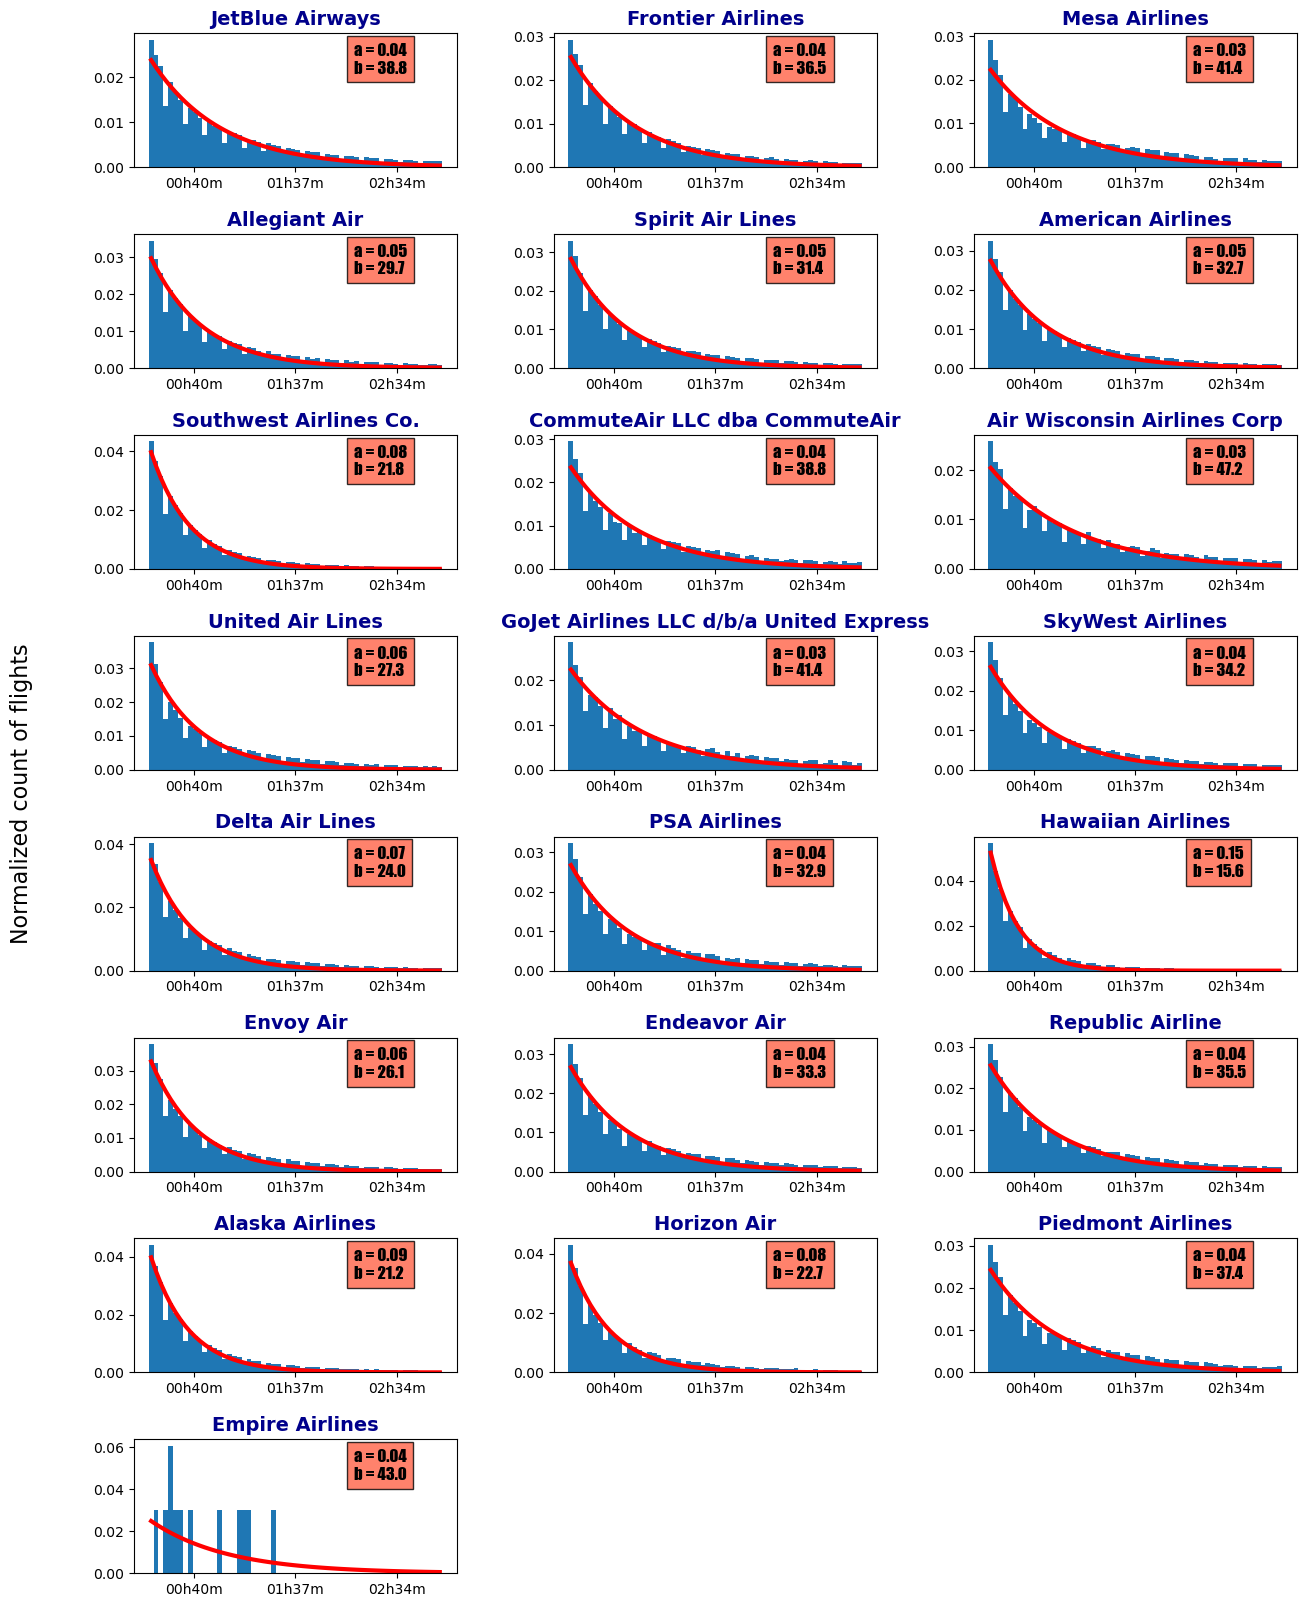

In [43]:
#low a value = LARGE amount of important delays
#high a value = small amount of delays (punctual)

num_carriers = len(global_stats.index)
num_rows = (num_carriers + 2) // 3
num_cols = min(num_carriers, 3)

fig = plt.figure(1, figsize=(15, 20))

for i, carrier_name in enumerate(global_stats.index, start=1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    
    #fit of the distribution
    n, bins, patches = plt.hist(x=cleaned_df[cleaned_df['AIRLINE'] == carrier_name]['DEP_DELAY'],
                                range=(15, 180), density=True, bins=60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    
    #function to fit the histogram
    def func(x, a, b):
        return a * np.exp(-x / b)
    
    #curve fitting
    popt, pcov = curve_fit(func, bin_centers, n, p0=[1, 2])
    
    #draw fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)
    
    #calculate middle time delay and 25% deviation
    middle_delay = np.median(bin_centers)
    deviation = np.percentile(bin_centers, 25)
    
    #set tick positions and labels
    tick_positions = [middle_delay - deviation, middle_delay, middle_delay + deviation]
    tick_labels = ['{:02d}h{:02d}m'.format(*divmod(int(x), 60)) for x in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    
    #subplot title
    plt.title(carrier_name, fontsize=14, fontweight='bold', color='darkblue')
    
    #legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0], 2), round(popt[1], 1)),
            style='italic', transform=ax.transAxes, fontsize=12, family='fantasy',
            bbox={'facecolor': 'tomato', 'alpha': 0.8, 'pad': 5})
    
    #add label for Normalized count of flights
    if i == num_rows * num_cols // 2:  #Check if this subplot is in the middle
        fig.text(0.05, 0.5, 'Normalized count of flights', fontsize=16, rotation=90,
                  color='k', horizontalalignment='center', verticalalignment='center')
    

#adjust margins between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

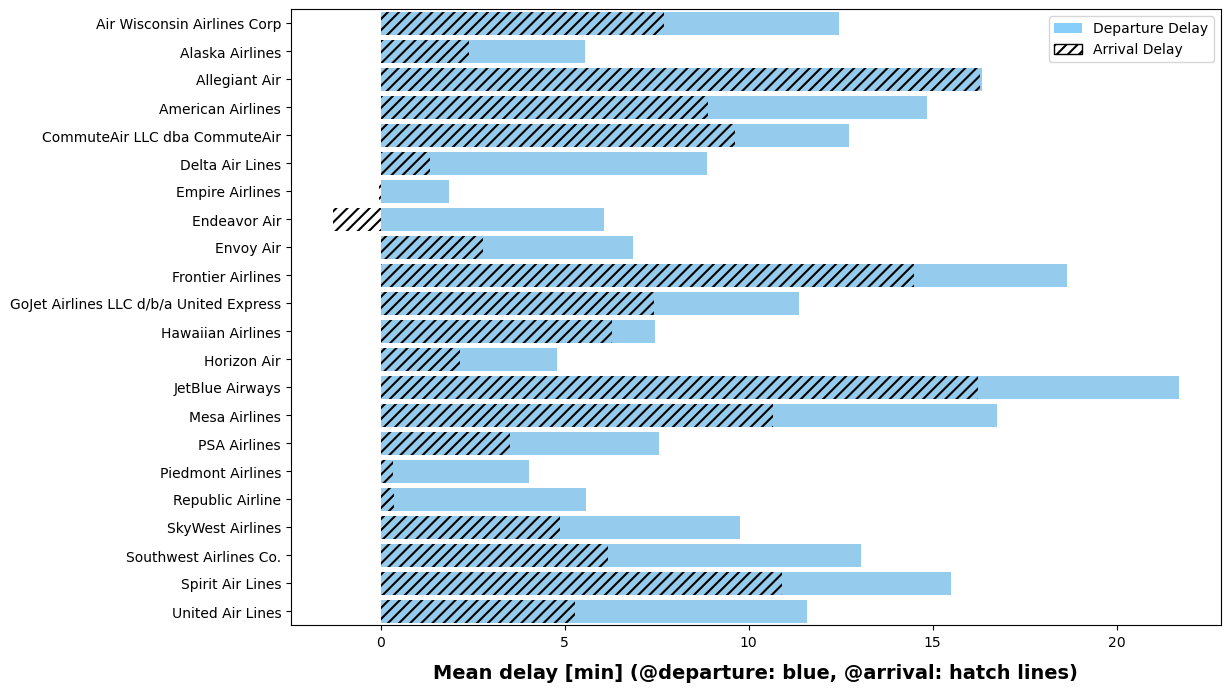

In [44]:
#delays at ARRIVAL are generally LOWER than at departure

#set hatch linewidth
plt.rcParams['hatch.linewidth'] = 1.5
fig = plt.figure(1, figsize=(12,8))
ax = sns.barplot(x='DEP_DELAY', y='AIRLINE', data=cleaned_df, color='lightskyblue', errorbar=None)
ax = sns.barplot(x='ARR_DELAY', y='AIRLINE', data=cleaned_df, color='r', hatch='///', alpha=0.0, errorbar=None)

#tick labels from y-axis
labels = [item.get_text() for item in ax.get_yticklabels()]

#set tick labels as the y-axis labels
ax.set_yticklabels(labels)

#hide y-axis label
ax.yaxis.label.set_visible(False)

#set x-axis label
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)', fontsize=14, weight='bold', labelpad=10)

#create legend
handles = [plt.Rectangle((0,0),1,1,fc='lightskyblue', edgecolor = 'none'),
           plt.Rectangle((0,0),1,1,fc='none', hatch = '///', edgecolor = 'black')]
labels = ['Departure Delay', 'Arrival Delay']
plt.legend(handles, labels)
plt.show()

C:\Users\cj.alonzo\AppData\Local\Temp\ipykernel_19856\1902704950.py:9: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.



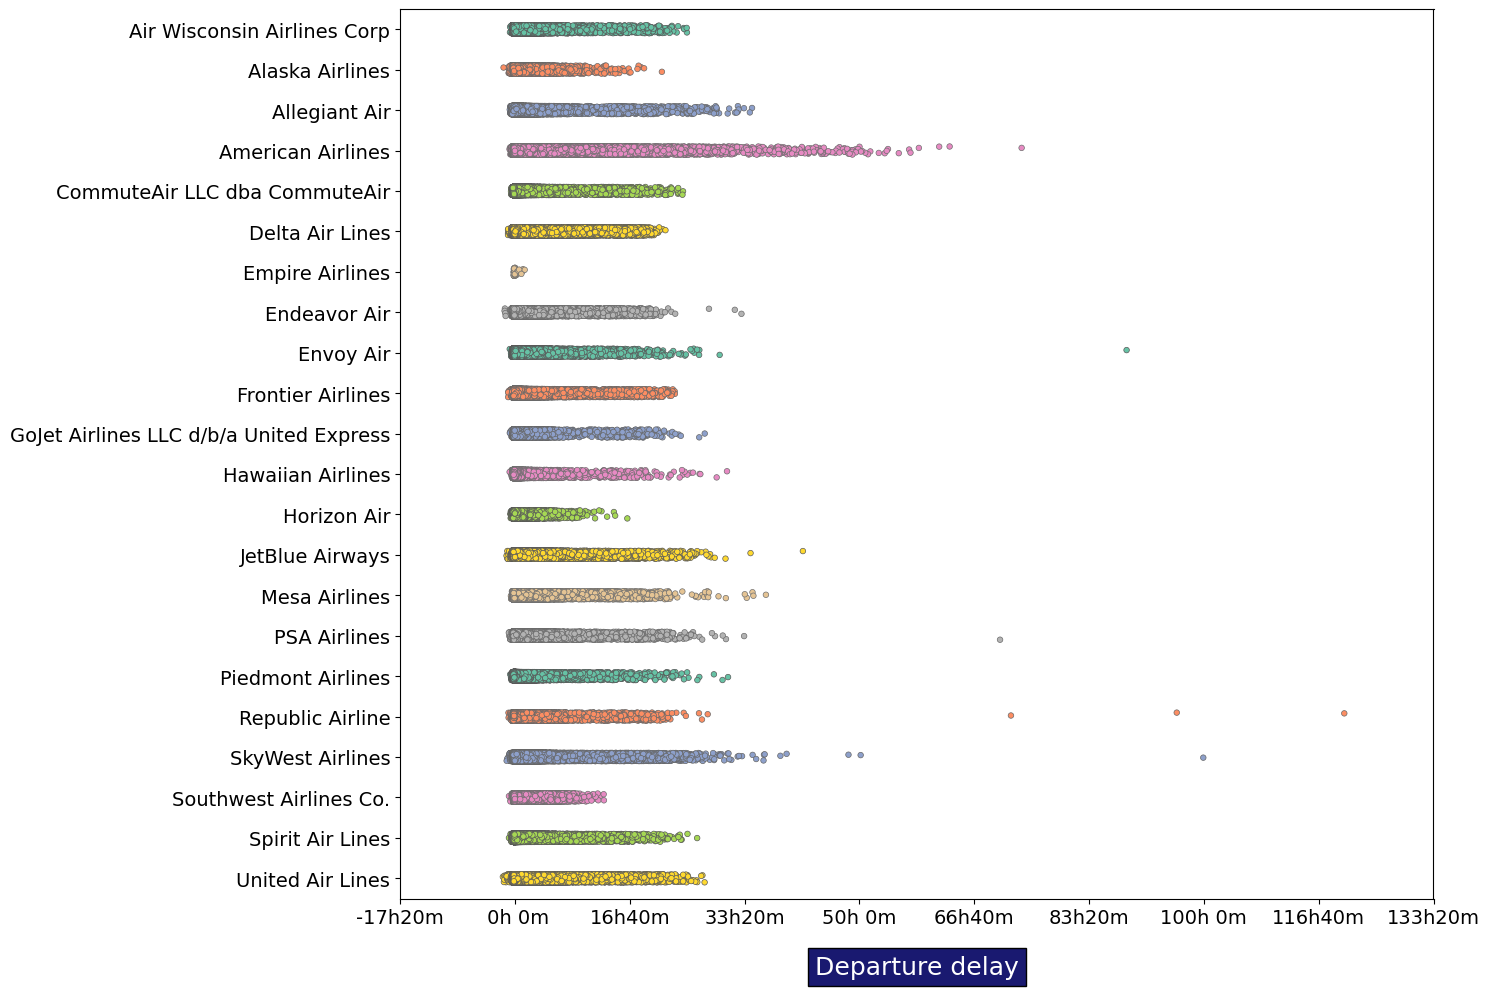

In [45]:
#count the number of unique airlines
num_unique_airlines = cleaned_df['AIRLINE'].nunique()

#generate a custom color palette with the appropriate number of colors
colors = sns.color_palette("Set2", n_colors=num_unique_airlines)

#plot the stripplot with the custom palette
plt.figure(figsize=(15, 10))
ax3 = sns.stripplot(y="AIRLINE", x="DEP_DELAY", size=4, palette=colors,
                    data=cleaned_df, linewidth=0.5, jitter=True)

plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticks(ax3.get_xticks())
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*divmod(x, 60)) for x in ax3.get_xticks()],
                    fontsize=14)

plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor': 'midnightblue', 'pad': 5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)

plt.tight_layout(w_pad=3)
plt.show()

In [46]:
#cleaned_df on how many delays
global_stats = cleaned_df['DEP_DELAY'].groupby(cleaned_df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

min     max      count       mean
AIRLINE                                                                     
Empire Airlines                          -11.0    85.0      112.0   1.848214
GoJet Airlines LLC d/b/a United Express  -44.0  1653.0   151948.0  11.362025
Air Wisconsin Airlines Corp              -43.0  1498.0   199304.0  12.460096
Hawaiian Airlines                        -46.0  1847.0   213181.0   7.468700
CommuteAir LLC dba CommuteAir            -34.0  1464.0   219244.0  12.731030
Horizon Air                              -38.0   979.0   264462.0   4.799483
Piedmont Airlines                        -41.0  1856.0   279209.0   4.030164
Allegiant Air                            -45.0  2065.0   338693.0  16.338312
Mesa Airlines                            -35.0  2186.0   351877.0  16.760260
Frontier Airlines                        -59.0  1393.0   459237.0  18.648942
PSA Airlines                             -53.0  4225.0   618362.0   7.573755
Alaska Airlines                          -99.0  1280.0   649440.0   5.568804
Spirit Air Lines                         -52.0  1587.0   669156.0  15.507214
Endeavor Air                             -90.0  1973.0   685728.0   6.073499
Envoy Air                                -45.0  5327.0   716184.0   6.866717
JetBlue Airways                          -73.0  2508.0   728358.0  21.685740
Republic Airline                         -56.0  7223.0   914376.0   5.580630
United Air Lines                        -105.0  1652.0  1772675.0  11.576812
SkyWest Airlines                         -72.0  5995.0  2121314.0   9.758937
American Airlines                        -47.0  4413.0  2491826.0  14.858477
Delta Air Lines                          -60.0  1311.0  2593171.0   8.865507
Southwest Airlines Co.                   -52.0   775.0  3721863.0  13.062114

In [47]:
airport_mean_delays = pd.DataFrame(pd.Series(cleaned_df['ORIGIN'].unique()))
airport_mean_delays.set_index(0, drop=True, inplace=True)

for airline_name in cleaned_df['AIRLINE'].unique():
    cleaned_df1 = cleaned_df[cleaned_df['AIRLINE'] == airline_name]
    test = cleaned_df1['DEP_DELAY'].groupby(cleaned_df['ORIGIN']).apply(get_stats).unstack()
    airport_mean_delays[airline_name] = test.loc[:, 'mean']

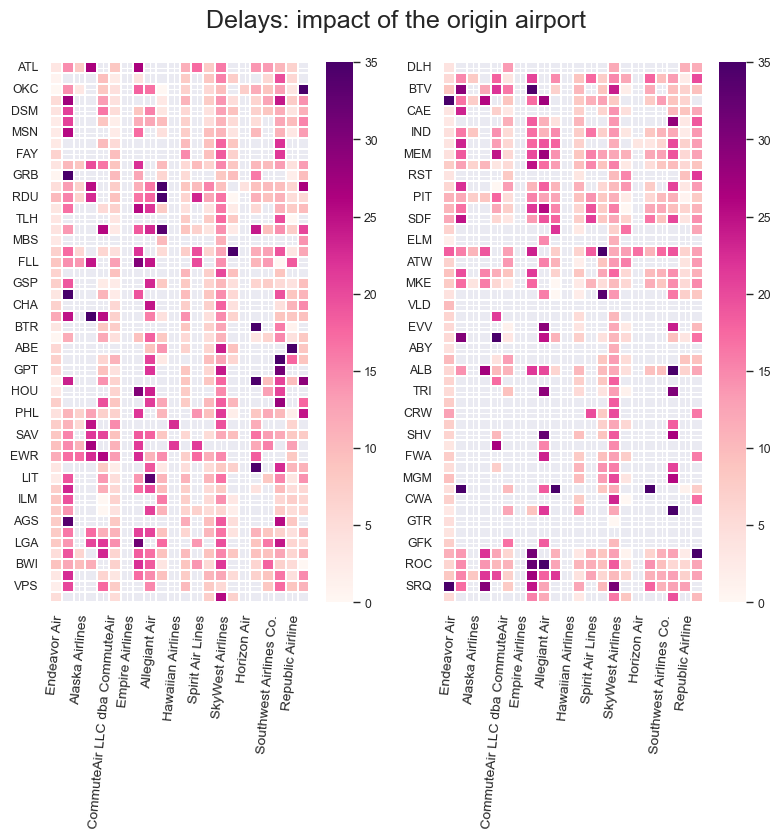

In [48]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns=cleaned_df['AIRLINE'])
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="RdPu", mask=mask, vmin=0, vmax=35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation=85)
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)
subset = airport_mean_delays.iloc[50:100,:].rename(columns=cleaned_df['AIRLINE'])
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize=18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="RdPu", mask=mask, vmin=0, vmax=35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation=85)
ax.yaxis.label.set_visible(False)

plt.tight_layout()

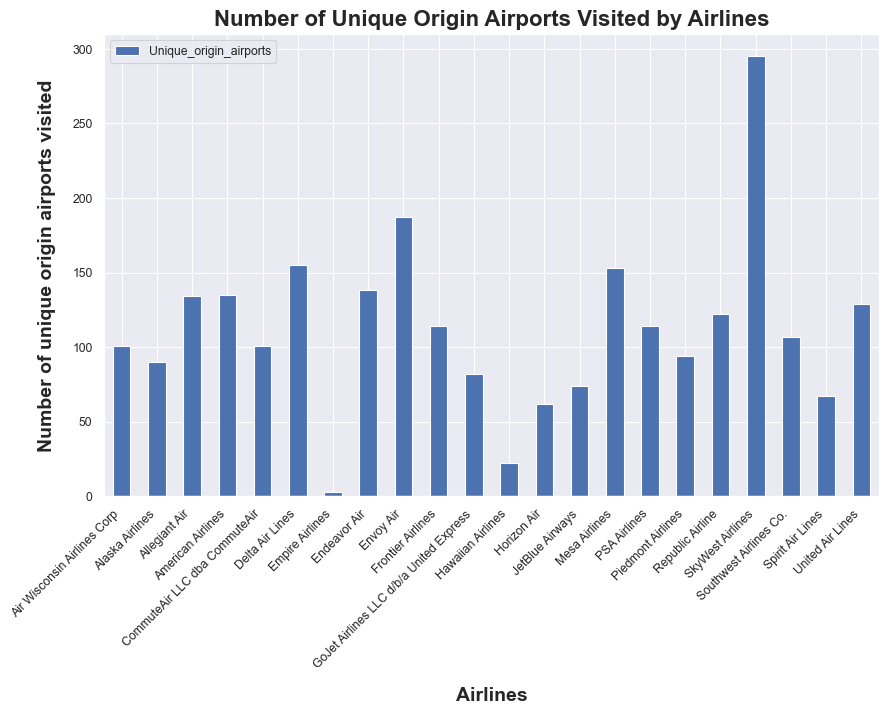

In [49]:
#count the number of unique origin airports visited per airline
unique_origin_airports = cleaned_df.groupby('AIRLINE')['ORIGIN'].nunique().reset_index()

#rename the column for clarity
unique_origin_airports.rename(columns={'ORIGIN': 'Unique_origin_airports'}, inplace=True)

#plot the bar chart
ax = unique_origin_airports.set_index('AIRLINE').plot(kind='bar', figsize=(10, 6))

#set labels and title
plt.ylabel('Number of unique origin airports visited', fontsize=14, weight='bold', labelpad=12)
plt.xlabel('Airlines', fontsize=14, weight='bold', labelpad=12)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Unique Origin Airports Visited by Airlines', fontsize=16, weight='bold')

plt.show()